In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import cv2
import gc
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tqdm import tqdm

In [2]:
import pathlib
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_labels = pd.read_csv("drive/My Drive/Colab Notebooks/FYP/train_v2.csv")

labels = []
for l in train_labels.tags.values:
  labels0 = l.split(" ")
  for label in labels0:
    if label not in labels:
      labels.append(label)


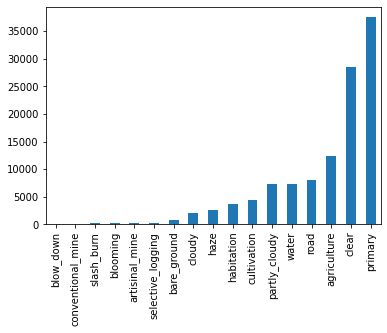

In [ ]:
# visualise the labels from the training data
for label in labels:
  train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(" ") else 0)

train_labels[labels].sum().sort_values().plot.bar()

In [3]:
label_map = {'agriculture': 1,
 'artisinal_mine': 5,
 'bare_ground': 0,
 'blooming': 16,
 'blow_down': 12,
 'clear': 6,
 'cloudy': 14,
 'conventional_mine': 15,
 'cultivation': 7,
 'habitation': 10,
 'haze': 3,
 'partly_cloudy': 4,
 'primary': 2,
 'road': 8,
 'selective_logging': 11,
 'slash_burn': 9,
 'water': 13}

In [ ]:
# load the training images and save .npy file
x_train = []
y_train = []
img_size = 64

df_train = pd.read_csv('drive/My Drive/Colab Notebooks/FYP/train_v2.csv')

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('drive/My Drive/Colab Notebooks/FYP/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (img_size, img_size)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.
np.save('drive/My Drive/Colab Notebooks/FYP/planet_x_train', x_train)
np.save('drive/My Drive/Colab Notebooks/FYP/planet_y_train', y_train)

In [4]:
# load np array
x_train = np.load('drive/My Drive/Colab Notebooks/FYP/planet_x_train.npy')
y_train = np.load('drive/My Drive/Colab Notebooks/FYP/planet_y_train.npy')
split = 5000
img_size = 64
x_train, x_valid, y_train, y_valid = x_train[split:], x_train[:split], y_train[split:], y_train[:split]

In [5]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((35479, 64, 64, 3), (35479, 17), (5000, 64, 64, 3), (5000, 17))

In [6]:
# define the model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 96)        55392     
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 128)       110720    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 256)       2

In [8]:
history = model.fit(x_train, y_train, batch_size=128, epochs=8, verbose=1, validation_data=(x_valid, y_valid))

p_valid = model.predict(x_valid, batch_size=128)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

Epoch 1/8
278/278 [==============================] - 20s 30ms/step - loss: 0.2636 - accuracy: 0.6082 - val_loss: 0.2288 - val_accuracy: 0.6214
Epoch 2/8
278/278 [==============================] - 8s 29ms/step - loss: 0.2143 - accuracy: 0.6284 - val_loss: 0.1880 - val_accuracy: 0.6352
Epoch 3/8
278/278 [==============================] - 9s 31ms/step - loss: 0.1928 - accuracy: 0.6245 - val_loss: 0.1774 - val_accuracy: 0.6322
Epoch 4/8
278/278 [==============================] - 8s 30ms/step - loss: 0.1775 - accuracy: 0.6150 - val_loss: 0.1627 - val_accuracy: 0.6162
Epoch 5/8
278/278 [==============================] - 8s 29ms/step - loss: 0.1670 - accuracy: 0.5978 - val_loss: 0.1511 - val_accuracy: 0.6170
Epoch 6/8
278/278 [==============================] - 8s 29ms/step - loss: 0.1604 - accuracy: 0.5936 - val_loss: 0.1483 - val_accuracy: 0.6284
Epoch 7/8
278/278 [==============================] - 8s 30ms/step - loss: 0.1555 - accuracy: 0.5910 - val_loss: 0.1471 - val_accuracy: 0.6248
Epoch

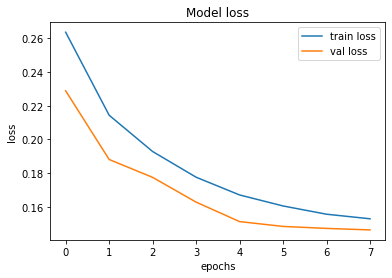

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()


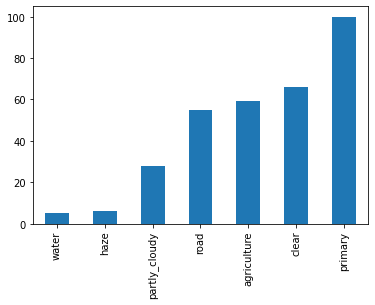

In [14]:
# evaluate with manually labelled images
man_labels = pd.read_csv("/content/manual_sequence_labels (6).csv")

labels = []
for l in man_labels.tags.values:
  labels0 = l.split(" ")
  for label in labels0:
    if label not in labels:
      labels.append(label)

for label in labels:
  man_labels[label] = man_labels['tags'].apply(lambda x: 1 if label in x.split(" ") else 0)

man_labels[labels].sum().sort_values().plot.bar()

In [15]:
man_imgs = []
man_tags = []
images = []
for i, f in enumerate(man_labels.values):
  img = cv2.imread("drive/My Drive/Colab Notebooks/FYP/Manual Labels/{}.tif".format(f[0]))
  images.append(img)
  tags = f[1]
  if img is not None:
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    img = cv2.resize(img, (64, 64))
    man_imgs.append(img)
    man_tags.append(targets)
  else:
    print(i)

man_tags = np.array(man_tags, np.uint8)
man_imgs = np.array(man_imgs, np.float16) / 255.

In [16]:
man_preds = model.predict(man_imgs)

In [17]:
print(fbeta_score(man_tags, man_preds > 0.2, beta=2, average='samples'))

0.8540131646152811


In [24]:
# Return a list of dates to search
def get_dates(date_interval, start, end):
  dates = []
  date = start
  while date < end:
    dates.append(np.datetime_as_string(date + np.timedelta64(0, 'D')))
    date = date + np.timedelta64(date_interval, 'M')
  return dates

In [ ]:
# use the model to save predictions
seq_train = np.zeros((233, 13, 20, 20, 17))
seq_dir = "/content/drive/My Drive/Colab Notebooks/FYP/sequence training data/"
# due to some errors collecting sequences, search_geoms contains the locations to search
search_geoms = np.load("/content/drive/My Drive/Colab Notebooks/FYP/search_geoms.npy") 
start = np.datetime64('2019-01')  # Date to start sequence
end = np.datetime64('2022-04')    # Date to end sequence
date_interval = 3
dates = get_dates(date_interval, start, end)

for i, g in enumerate(search_geoms):
  print("{}/{}".format(g, len(search_geoms)))
  cropped_imgs = np.load(seq_dir + str(g) + ".npy")
  for d in range(13):
    imgs = cropped_imgs[d]
    imgs = np.array(imgs, np.float16) / 255.
    predictions = model.predict(imgs)
    for n in range(400):
      row, col = int(n/20), n%20
      seq_train[i, d, row, col] = predictions[n]


In [27]:
np.save("/content/drive/My Drive/Colab Notebooks/FYP/seq_train", seq_train)